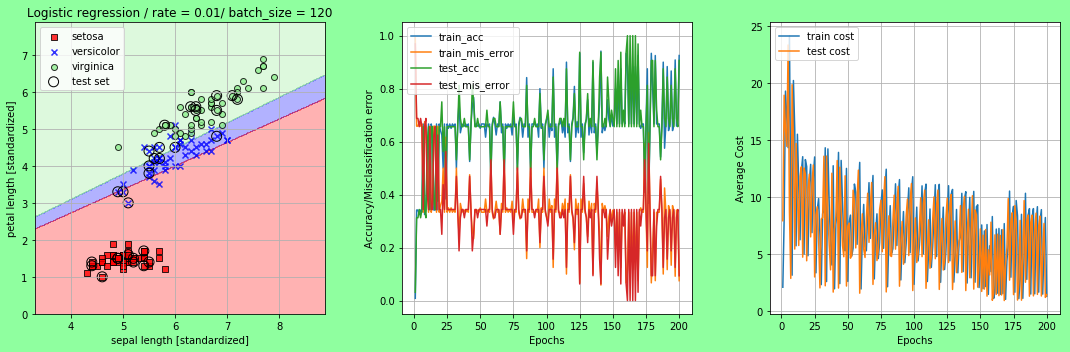

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

df = pd.read_csv('http://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data', header=None)
df.tail()

setosa = df.loc[:50, :].values
versicolor = df.loc[50:100, :].values
virginica = df.loc[100:150, :].values
np.random.shuffle(setosa)
np.random.shuffle(versicolor)
np.random.shuffle(virginica)

x_train = np.concatenate((setosa[:40, [0, 2]], versicolor[:40, [0, 2]], virginica[:40, [0, 2]])).astype(np.float64)
y_train = np.concatenate((setosa[:40, 4], versicolor[:40, 4], virginica[:40, 4]))
y_train = np.where(y_train == 'Iris-setosa', 0, np.where(y_train == 'Iris-versicolor', 1, 2))

x_test = np.concatenate((setosa[40:, [0, 2]], versicolor[40:, [0, 2]], virginica[40:, [0, 2]])).astype(np.float64)
y_test = np.concatenate((setosa[40:, 4], versicolor[40:, 4], virginica[40:, 4]))
y_test = np.where(y_test == 'Iris-setosa', 0, np.where(y_test == 'Iris-versicolor', 1, 2))

x_total = np.concatenate((x_train, x_test))
y_total = np.concatenate((y_train, y_test))

test_idx = list(range(120, 150))


def Standardization(x):
    X_std = np.copy(x)
    X_std[:, 0] = (x[:, 0] - x[:, 0].mean()) / x[:, 0].std()
    X_std[:, 1] = (x[:, 1] - x[:, 1].mean()) / x[:, 1].std()
    return X_std


def Normalization(x):
    X_nor = np.copy(x)
    X_nor[:, 0] = (x[:, 0] - x[:, 0].min()) / (x[:, 0].max() - x[:, 0].min())
    X_nor[:, 1] = (x[:, 1] - x[:, 1].min()) / (x[:, 1].max() - x[:, 1].min())
    return X_nor


x_train_std = Standardization(x_train)
x_test_std = Standardization(x_test)
x_train_nor = Normalization(x_train)
x_test_nor = Normalization(x_test)
x_std_total = np.concatenate((x_train_std, x_test_std))
y_std_total = np.concatenate((y_train, y_test))
x_nor_total = np.concatenate((x_train_nor, x_test_nor))
y_nor_total = np.concatenate((y_train, y_test))


class Logistic_regression(object):
    def __init__(self, learning_rate=0.01, epoch=10, shuffle=True, random_state=None, batch_size=1):
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        self.batch_size = batch_size

    def fit(self, X, y, X_test, y_test):
        self._initialize_weights(X.shape[1], 3)
        self.cost_ = []
        self.t_cost = []
        self.correct_sum = 0
        self.tr_mis_error = []
        self.tr_acc = []
        self.ts_mis_error = []
        self.ts_acc = []

        for i in range(self.epoch):
            self.accuracy = y - self.predict(X)
            for k in range(len(self.accuracy)):
                if self.accuracy[k] == 0:
                    self.correct_sum += 1
            self.tr_acc.append(self.correct_sum / len(y))
            self.tr_mis_error.append(1 - self.correct_sum / len(y))
            self.correct_sum = 0

            self.accuracy = y_test - self.predict(X_test)
            for k in range(len(self.accuracy)):
                if self.accuracy[k] == 0:
                    self.correct_sum += 1
            self.ts_acc.append(self.correct_sum / len(y_test))
            self.ts_mis_error.append(1 - self.correct_sum / len(y_test))
            self.correct_sum = 0

            iteration = int(X.shape[0] / self.batch_size)
            for j in range(iteration):
                cost = []
                b_X = X[self.batch_size * j:self.batch_size * (j + 1)]
                b_y = y[self.batch_size * j:self.batch_size * (j + 1)]
                y_onehot = np.eye(int(np.max(y)) + 1)[np.array(y, dtype=int)]
                cost.append(self._update_weights(b_X, b_y))
            avg_cost = sum(cost) / (self.batch_size * iteration)
            self.cost_.append(avg_cost)

            testing_cost = []
            testing_cost.append(self.cost(X_test, y_test))
            t_avg_cost = sum(testing_cost) / len(y_test)
            self.t_cost.append(t_avg_cost)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m, class_num):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=(1 + m) * class_num)
        self.w_ = np.reshape(self.w_, (1 + m, class_num))
        self.w_initialized = True

    def cost(self, xi, target):
        output = self.activation(self.net_input(xi))
        one_hot = np.eye(3)[np.array(target, dtype=int)]
        cost = []
        for i in range(len(target)):
            cost.append(-np.inner(one_hot[i], (np.log(output[i]))) - (np.inner((1 - one_hot[i]), (np.log(1 - output[i])))))
        cost = np.array(cost)
        return cost

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        one_hot = np.eye(3)[np.array(target, dtype=int)]
        error = (one_hot - output)
        self.w_[1:, :] += self.learning_rate * xi.T.dot(error)
        self.w_[0, :] += self.learning_rate * np.sum(error, axis=0)
        cost = []
        for i in range(len(target)):
            cost.append(-np.inner(one_hot[i], (np.log(output[i]))) - (np.inner((1 - one_hot[i]), (np.log(1 - output[i])))))
        cost = np.array(cost)
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:, :]) + self.w_[0, :]

    def activation(self, z):
        return 1. / (1. + np.exp(-z))

    def predict(self, X):
        return np.argmax(self.activation(self.net_input(X)), axis=1)


def plot_decision_regions(X, y, learn, batch, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)  # reshape the predicted class labels z into a grid with the same dimensions as xx1 and xx2
    plt.figure(figsize=(15, 5)).patch.set_facecolor('xkcd:mint green')
    plt.subplot(1, 3, 1)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)  # draw a contour plot via Matplotlib's contourf function
    plt.xlim(xx1.min(), xx1.max())  # maps the different decision reginos to different colors
    plt.ylim(xx2.min(), xx2.max())  # for each predicted class in the grid array
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=flower(cl),
                    edgecolor='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black', alpha=1.0, linewidth=1, marker='o', s=100,
                    label='test set')

    a = 'Logistic regression / rate = ' + str(learn) + "/ batch_size = " + str(batch)
    plt.title(a)
    plt.xlabel('sepal length [standardized]')
    plt.ylabel('petal length [standardized]')
    plt.legend(loc='upper left')
    plt.grid()
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(classifier.tr_acc) + 1), classifier.tr_acc, label='train_acc')
    plt.plot(range(1, len(classifier.tr_mis_error) + 1), classifier.tr_mis_error, label='train_mis_error')
    plt.plot(range(1, len(classifier.ts_acc) + 1), classifier.ts_acc, label='test_acc')
    plt.plot(range(1, len(classifier.ts_mis_error) + 1), classifier.ts_mis_error, label='test_mis_error')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/Misclassification error')
    plt.legend(loc='upper left')
    plt.grid()
    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(classifier.cost_) + 1), classifier.cost_, label='train cost')
    plt.plot(range(1, len(classifier.t_cost) + 1), classifier.t_cost, label='test cost')
    plt.xlabel('Epochs')
    plt.ylabel('Average Cost')
    plt.legend(loc='upper left')
    plt.grid()


def flower(x):
    if x == 0:
        return 'setosa'
    elif x == 1:
        return 'versicolor'
    else:
        return 'virginica'


def model_Org(learn=0.1, batch=1):
    adaSGD = Logistic_regression(epoch=200, learning_rate=learn, random_state=1, batch_size=batch)
    adaSGD.fit(x_train, y_train, x_test, y_test)
    plot_decision_regions(x_total, y_total, learn, batch, classifier=adaSGD, test_idx=test_idx)
    plt.tight_layout()
    plt.show()
def model_Std(learn=0.1, batch=1):
    adaSGD = Logistic_regression(epoch=50, learning_rate=learn, random_state=1, batch_size=batch)
    adaSGD.fit(x_train_std, y_train, x_test_std, y_test)
    plot_decision_regions(x_std_total, y_std_total, learn, batch, classifier=adaSGD, test_idx=test_idx)
    plt.tight_layout()
    plt.show()
def model_Nor(learn=0.1, batch=1):
    adaSGD = Logistic_regression(epoch=50, learning_rate=learn, random_state=1, batch_size=batch)
    adaSGD.fit(x_train_nor, y_train, x_test_nor, y_test)
    plot_decision_regions(x_nor_total, y_nor_total, learn, batch, classifier=adaSGD, test_idx=test_idx)
    plt.tight_layout()
    plt.show()


model_Org(0.01, 120)

In [107]:
# 기본 데이터셋으로 실험한결과 분류가 잘되지 않는것을 확인할수있엇고 epoch을 50회했을때 cost가 그닥 수렴하지 않았다
# 하지만 epcoh을 늘린결과에선 느리지만 점차 수렴해서 분류가 시작 되는것을 확인했었다.

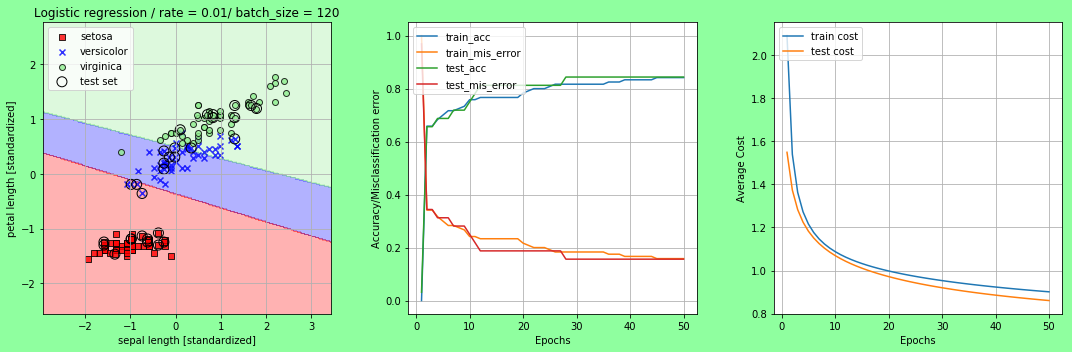

In [108]:
model_Std(0.01, 120)

In [109]:
# 데이터를 standardization 한결과 코스트는 수렴하여 분류가 잘되었고 acc도 0.8 이상의 성능을 보였다

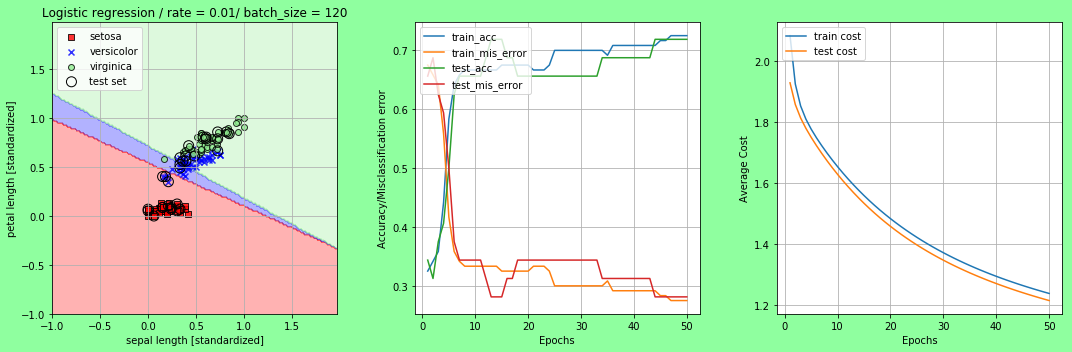

In [110]:
model_Nor(0.01, 120)

In [111]:
#  normalize 한결과에서도 코스트는 점점 수렴했으며 어느정도 분류가 된것을 확인할수있었다.

Linear SVM with Standardization : Test Accuracy : 1.000000
Linear SVM with Normalization : Test Accuracy : 0.968750


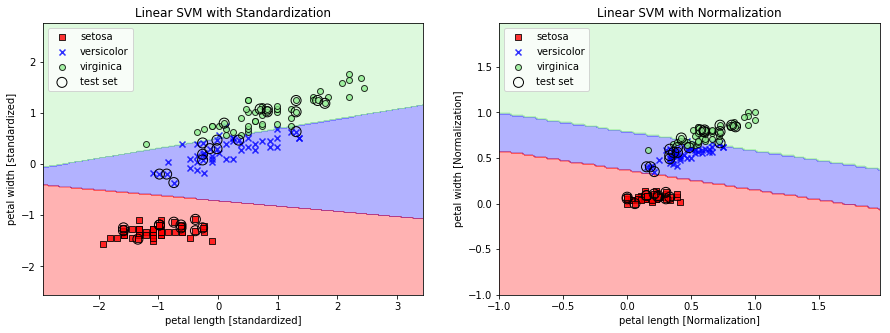

In [122]:
from sklearn.svm import SVC
std_svm = SVC(kernel='linear', C=1.0, random_state=1)
nor_svm = SVC(kernel='linear', C=1.0, random_state=1)

std_svm.fit(x_train_std, y_train)
nor_svm.fit(x_train_nor, y_train)

std_y_pred = std_svm.predict(x_test_std)
nor_y_pred = nor_svm.predict(x_test_nor)

def acc(pred, test):
    cor = 0
    mis = 0
    for i in range (len(pred)):
        if pred[i]==test[i]:
            cor=cor+1
        else:
            mis=mis+1
            
    return (cor/(mis+cor))

def plot_decision_regions2(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=flower(cl),
                    edgecolor='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black', alpha=1.0, linewidth=1, marker='o', s=100,
                    label='test set')

print("Linear SVM with Standardization : Test Accuracy : %f" %acc(std_y_pred,y_test))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_decision_regions2(x_std_total, y_std_total, classifier=std_svm, test_idx=range(120, 150))
plt.title('Linear SVM with Standardization')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

# Nomalization / linear SVM
print("Linear SVM with Normalization : Test Accuracy : %f" %acc(nor_y_pred,y_test))
plt.subplot(1,2,2)
plot_decision_regions2(x_nor_total, y_nor_total, classifier=nor_svm, test_idx=range(120, 150))
plt.title('Linear SVM with Normalization')
plt.xlabel('petal length [Normalization]')
plt.ylabel('petal width [Normalization]')
plt.legend(loc='upper left')
plt.show()

In [123]:
# 선형 svm을 실험한 결과 선형 결정경계가 날나왔고 accuracy가 잘나온것같다.

Non-linear SVM / Standardization Test acc : 1.000000
Non-linear SVM / Normalization Test acc : 0.968750


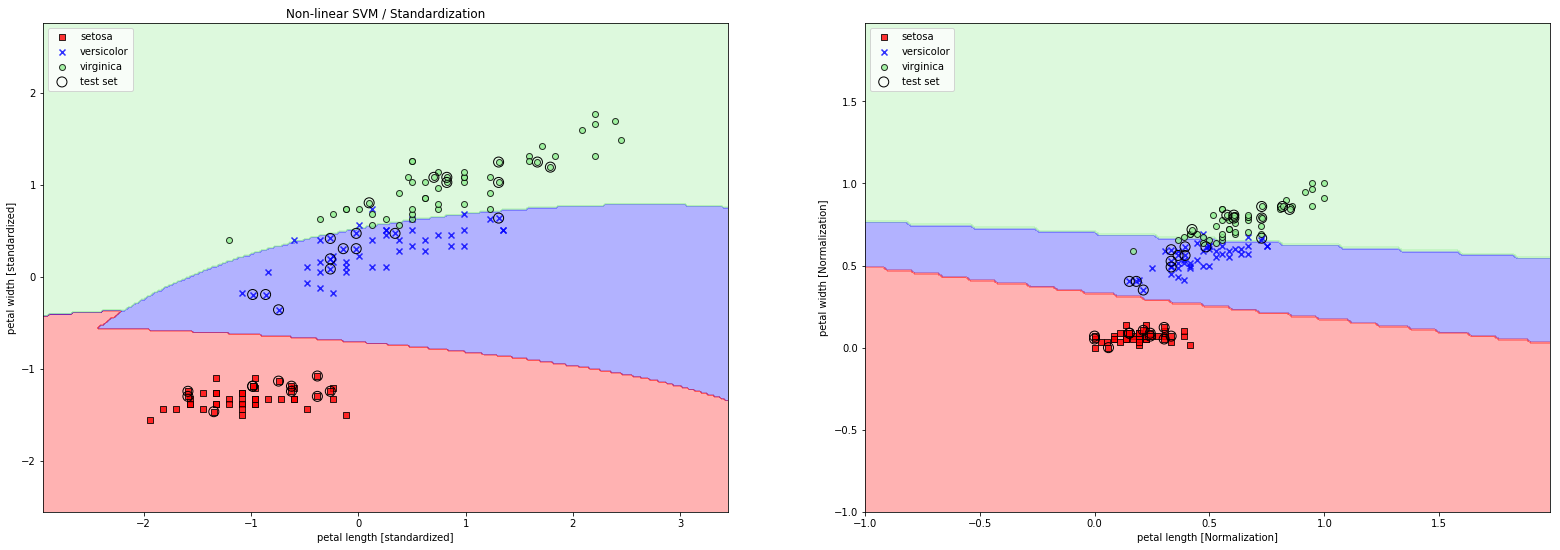

In [124]:
n_std_svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
n_nor_svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)

n_std_svm.fit(x_train_std, y_train)
n_nor_svm.fit(x_train_nor, y_train)

n_std_y_pred = std_svm.predict(x_test_std)
n_nor_y_pred = nor_svm.predict(x_test_nor)

print("Non-linear SVM / Standardization Test acc : %f" %acc(n_std_y_pred,y_test))
plt.figure(figsize=(27,9))
plt.subplot(1,2,1)
plot_decision_regions2(x_std_total, y_std_total, classifier=n_std_svm, test_idx=range(120, 150))
plt.title('Non-linear SVM / Standardization')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

# normalization / non-linear SVM
print("Non-linear SVM / Normalization Test acc : %f" %acc(n_nor_y_pred,y_test))
plt.subplot(1,2,2)
plot_decision_regions2(x_nor_total, y_nor_total, classifier=n_nor_svm, test_idx=range(120, 150))
plt.xlabel('petal length [Normalization]')
plt.ylabel('petal width [Normalization]')
plt.legend(loc='upper left')
plt.show()

In [125]:
# 비선형 svm으로 실험한결과  정확도가 높앗고 결정경계도 잘나온것같다.
# 그러나 normalize한 결과에있어서는 비선형 svm이지만 경계자체는 거의 선형인 모습을 보였다

RandomForest / standardization Test acc : 1.000000
RandomForest / normalization Test acc : 0.968750


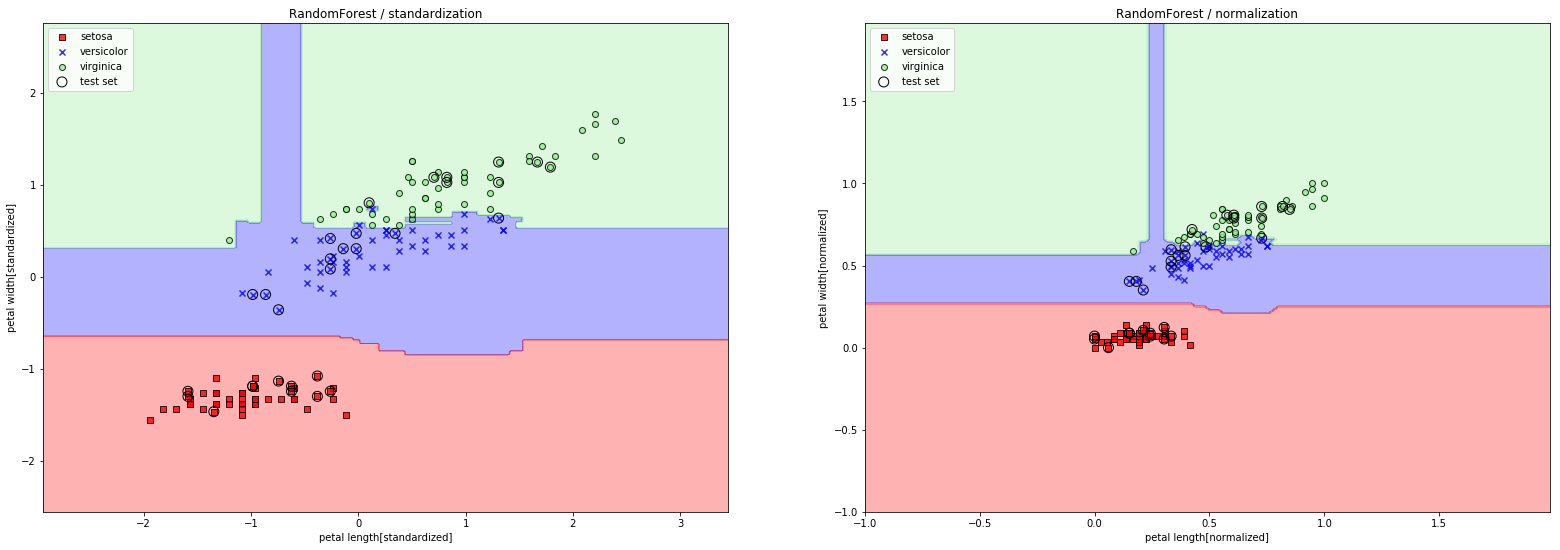

In [126]:
from sklearn.ensemble import RandomForestClassifier

std_forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=2)
std_forest.fit(x_train_std, y_train)

nor_forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=2)
nor_forest.fit(x_train_nor, y_train)

R_s_y_pred = std_svm.predict(x_test_std)
R_n_y_pred = nor_svm.predict(x_test_nor)

print("RandomForest / standardization Test acc : %f" %acc(R_s_y_pred,y_test))
plt.figure(figsize=(27,9))
plt.subplot(1,2,1)
plot_decision_regions2(x_std_total, y_std_total, classifier=std_forest, test_idx=range(120,150))
plt.title("RandomForest / standardization")
plt.xlabel('petal length[standardized]')
plt.ylabel('petal width[standardized]')
plt.legend(loc='upper left')

# Normalization RandomForest 
print("RandomForest / normalization Test acc : %f" %acc(R_n_y_pred,y_test))
plt.subplot(1,2,2)
plot_decision_regions2(x_nor_total, y_nor_total, classifier=nor_forest, test_idx=range(120,150))
plt.title("RandomForest / normalization")
plt.xlabel('petal length[normalized]')
plt.ylabel('petal width[normalized]')
plt.legend(loc='upper left')
plt.show()

In [127]:
# 중간중간 경계선이 갈라지는현상이있었지만 accuracy는 높고 경계자체는 잘나온것같다.

KNN-Euclid /standardization Test acc : 1.000000
KNN-Euclid / nomalization Test acc : 0.968750


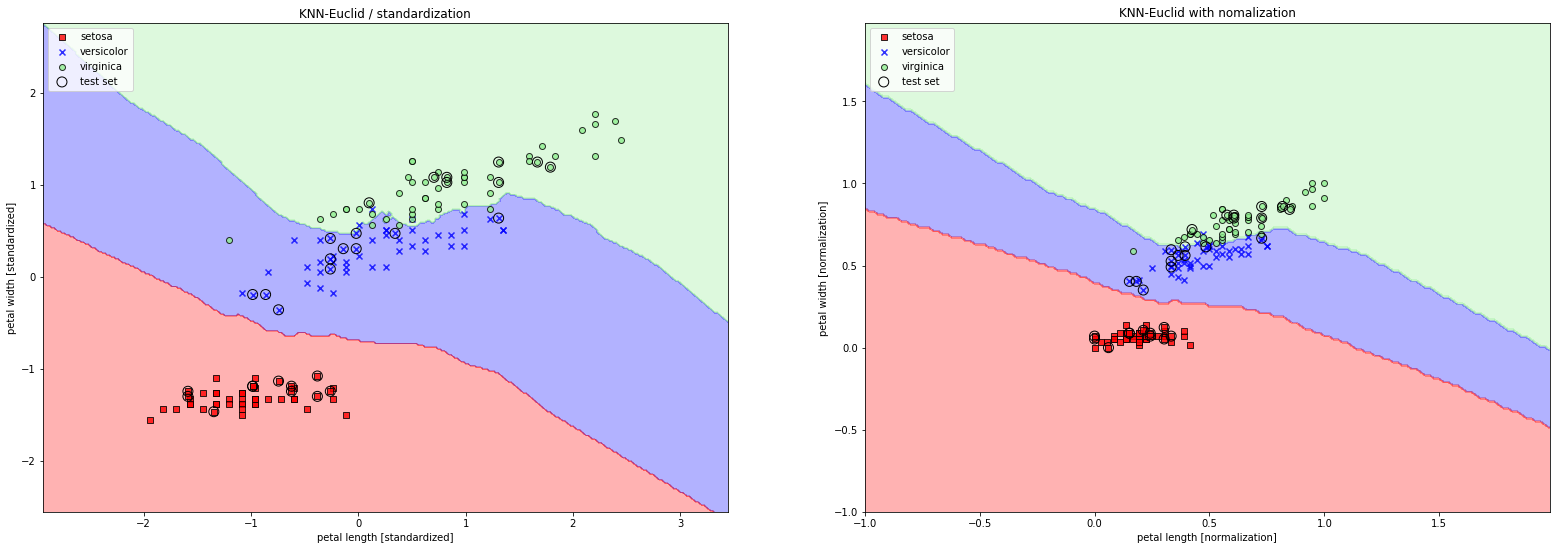

In [128]:
from sklearn.neighbors import KNeighborsClassifier

E_std_knn = KNeighborsClassifier(n_neighbors=6, p=2, metric='minkowski')
E_std_knn.fit(x_train_std, y_train)
E_nor_knn = KNeighborsClassifier(n_neighbors=6, p=2, metric='minkowski')
E_nor_knn.fit(x_train_nor, y_train)

E_std_pred = E_std_knn.predict(x_test_std)
E_nor_pred = E_nor_knn.predict(x_test_nor)

M_std_knn = KNeighborsClassifier(n_neighbors=6, p=1, metric='minkowski')
M_std_knn.fit(x_train_std, y_train)
M_nor_knn = KNeighborsClassifier(n_neighbors=6, p=1, metric='minkowski')
M_nor_knn.fit(x_train_std, y_train)

M_std_pred = M_std_knn.predict(x_train_std)
M_nor_pred = M_nor_knn.predict(x_train_nor)

print("KNN-Euclid /standardization Test acc : %f" %acc(E_std_pred, y_test))
plt.figure(figsize=(27,9))
plt.subplot(1,2,1)
plot_decision_regions2(x_std_total, y_std_total, classifier=E_std_knn, test_idx=range(120,150))
plt.title('KNN-Euclid / standardization')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

print("KNN-Euclid / nomalization Test acc : %f" %acc(E_nor_pred, y_test))
plt.subplot(1,2,2)
plot_decision_regions2(x_nor_total, y_nor_total, classifier=E_nor_knn, test_idx=range(120,150))
plt.title("KNN-Euclid with nomalization")
plt.xlabel('petal length [normalization]')
plt.ylabel('petal width [normalization]')
plt.legend(loc='upper left')

In [129]:
# 유클리디언 거리로 구한 KNN 오른쪽이 normal, 왼쪽이 standard 

KNN-manhatan with standardization Test acc : 1.000000
KNN-manhatan with normalization Test acc : 0.968750


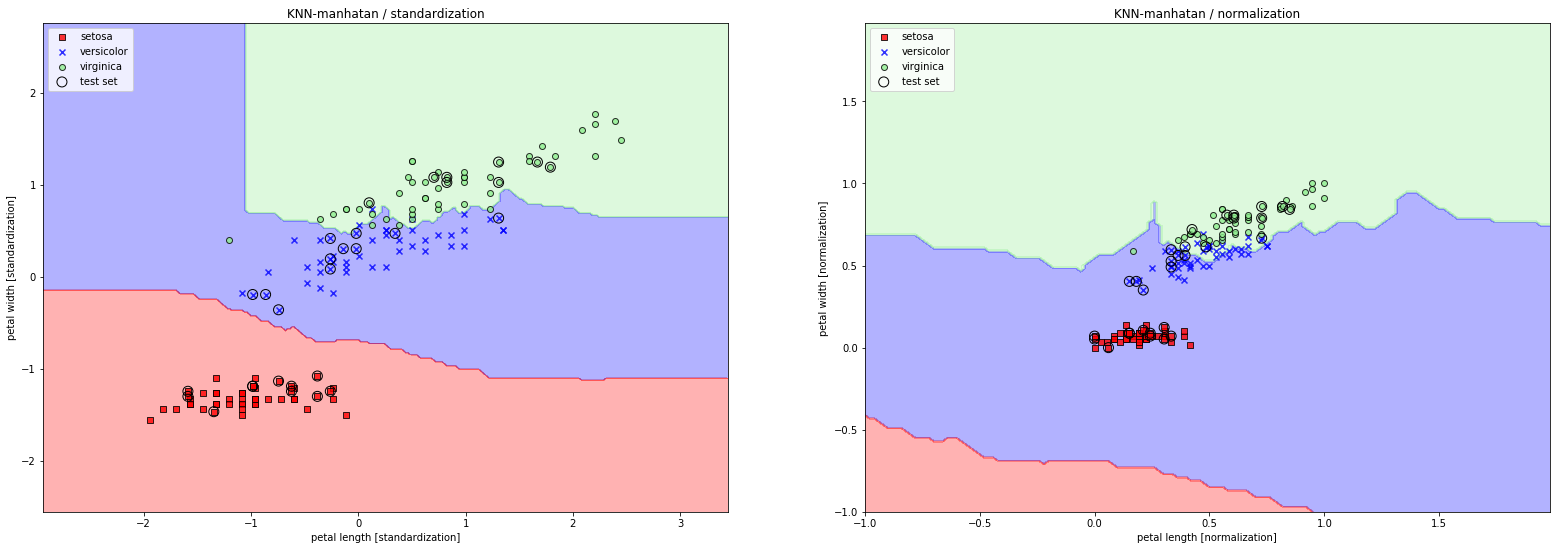

In [130]:
print("KNN-manhatan with standardization Test acc : %f" %acc(E_std_pred, y_test))
plt.figure(figsize=(27,9))
plt.subplot(1,2,1)
plot_decision_regions2(x_std_total, y_std_total, classifier=M_std_knn, test_idx=range(120,150))
plt.title("KNN-manhatan / standardization")
plt.xlabel('petal length [standardization]')
plt.ylabel('petal width [standardization]')
plt.legend(loc='upper left')

print("KNN-manhatan with normalization Test acc : %f" %acc(E_nor_pred, y_test))
plt.subplot(1,2,2)
plt.title("KNN-manhatan / normalization")
plot_decision_regions2(x_nor_total, y_nor_total, classifier=M_nor_knn, test_idx=range(120,150))
plt.xlabel('petal length [normalization]')
plt.ylabel('petal width [normalization]')
plt.legend(loc='upper left')

plt.show()

In [131]:
# 맨하탄거리로 구한 KNN 왼쪽이 standard, 오른쪽이 normal
# standardization을 한것보단 normalize한것이 경계가 좀더 분명하게 분류되었다